# Linear Regression

In [1]:
import math

import scipy.stats
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

sns.set(font_scale=1.5, palette='colorblind')

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
palette = sns.color_palette('colorblind')

In [3]:
def noisy_line(m, b, sigma, size):
    """
    Generate 2D line with added normal error ~ N(0, sigma**2)
    """
    xdata = np.linspace(-1.0, 1.0, size)
    errors = scipy.stats.norm.rvs(loc=0, scale=sigma, size=size)
    ydata = m * xdata + b + errors
    return xdata, ydata

theta_1, theta_0 = 2, 3
actual_stdev = 0.25
size = 100
xs, ys = noisy_line(theta_1, theta_0, actual_stdev, size)

In [4]:
# y = 2x + 3
y_f = lambda x: theta_1 * x + theta_0
y = y_f(xs)

In [5]:
def plot_line(x, y=None, ys=None, predictions=None):
    f, ax = plt.subplots(1, 1, figsize=(15, 6))
    
    palette = sns.color_palette('colorblind')
    
    if ys is not None:
        ax.plot(x, ys, 'o', label='Noisy data', color=palette[0])
    
    if y is not None:
        ax.plot(x, y, label=f'Actual line', color=palette[1])
    
    if predictions is not None:
        ax.plot(x, predictions, label='Fitted line', color=palette[2])

    ax.legend()
    return f, ax

(<Figure size 1080x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11a49b240>)

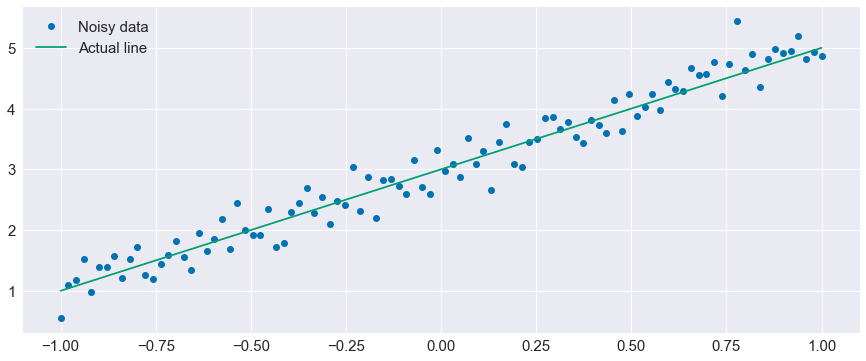

In [6]:
plot_line(xs, y, ys)

(<Figure size 1080x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11a56ce10>)

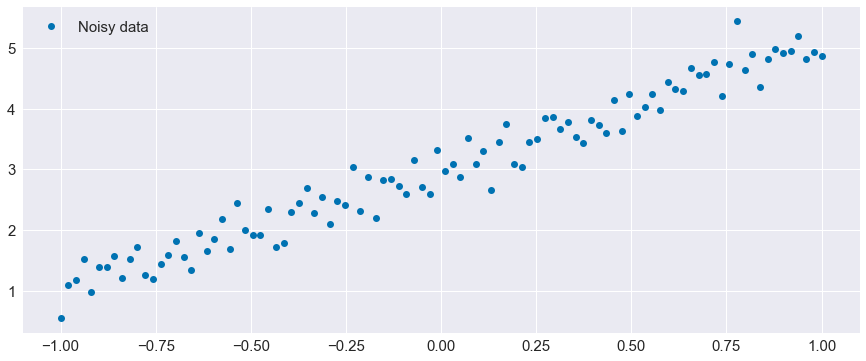

In [7]:
plot_line(xs, ys=ys)

In [8]:
learning_rate = 0.01

x_t = tf.placeholder(tf.float32, [None])
y_t = tf.placeholder(tf.float32, [None])

a = tf.get_variable('slope', dtype=tf.float32, shape=())
b = tf.get_variable('intercept', dtype=tf.float32, shape=())

y_pred = tf.add(tf.multiply(a, x_t), b)

loss = tf.reduce_mean(tf.square(y_pred - y_t))

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

In [9]:
init = tf.global_variables_initializer()

x_test = np.linspace(10.0, 100.0, size)
y_test = y_f(x_test)

In [10]:
n_epochs = 200
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        sess.run(train_op, feed_dict={x_t: xs, y_t: ys})
        
    mse = float(loss.eval(feed_dict={x_t: xs, y_t: ys}))
    slope, intercept = sess.run([a, b])
    y_hat = y_pred.eval(feed_dict={x_t: xs})
    y_hat_test = y_pred.eval(feed_dict={x_t: x_test})
    mse_test = float(loss.eval(feed_dict={x_t: x_test, y_t: y_test}))


Slope: 1.1699, intercept: 2.9687


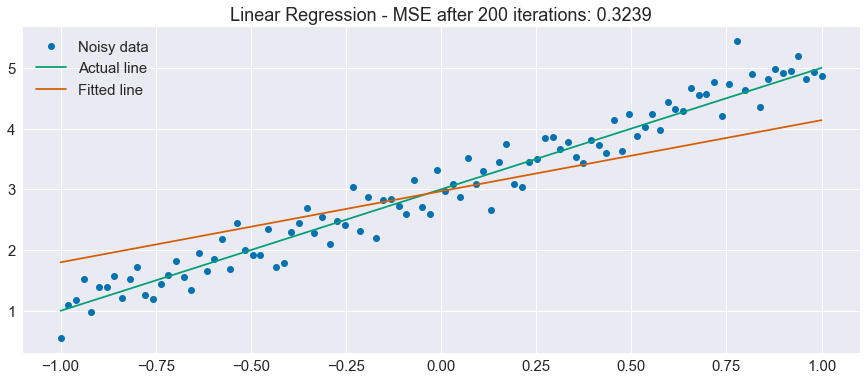

In [11]:
f, ax = plot_line(xs, y, ys, y_hat)
ax.set_title(f'Linear Regression - MSE after {n_epochs} iterations: {round(mse, 4)}')
print()
print(f'Slope: {round(float(slope), 4)}, intercept: {round(float(intercept), 4)}')

With normalization:

In [12]:
scale = lambda x, scaler: scaler.fit_transform(x.reshape((len(x), 1))).flatten()
inverse_scale = lambda x, scaler: scaler.inverse_transform(x.reshape((len(x), 1))).flatten()

In [13]:
def train_linear_regression(x, y, n_epochs):
    x_scaler, y_scaler = preprocessing.StandardScaler(), preprocessing.StandardScaler()
    x_n = scale(x, x_scaler)
    y_n = scale(y, y_scaler)

    saver = tf.train.Saver()
    with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            sess.run(train_op, feed_dict={x_t: x_n, y_t: y_n})

        return saver.save(sess, "./linreg.ckpt")

In [14]:
save_path = train_linear_regression(xs, ys, n_epochs)

In [15]:
def predict(x, y, save_path):
    x_scaler, y_scaler = preprocessing.StandardScaler(), preprocessing.StandardScaler()
    x_n = scale(x, x_scaler)
    y_n = scale(y, y_scaler)
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, save_path)
        
        y_hat_n, mse = sess.run([y_pred, loss], feed_dict={x_t: x_n, y_t: y_n})
        
    return inverse_scale(y_hat_n, y_scaler), float(mse)

In [16]:
y_hat, mse = predict(xs, ys, save_path)
y_hat_test, mse_test = predict(x_test, y_test, save_path)

INFO:tensorflow:Restoring parameters from ./linreg.ckpt
INFO:tensorflow:Restoring parameters from ./linreg.ckpt


Text(0.5,1,'Linear Regression - MSE after 200 iterations: 0.0458')

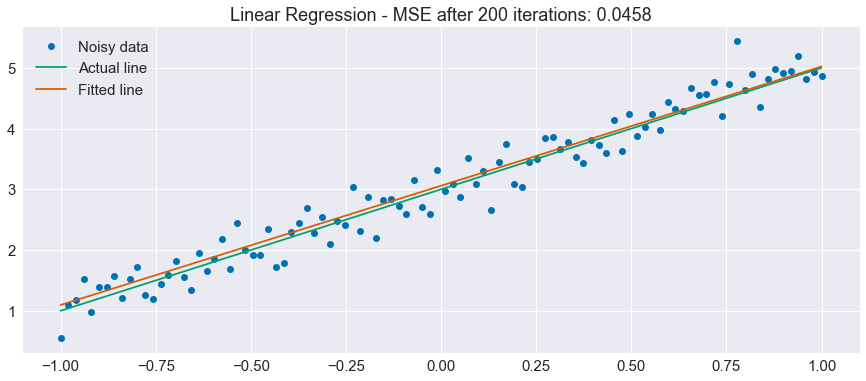

In [17]:
f, ax = plot_line(xs, y, ys, y_hat)
ax.set_title(f'Linear Regression - MSE after {n_epochs} iterations: {round(mse, 4)}')

## Model the error

In [18]:
learning_rate_eta = tf.placeholder(tf.float32, shape=())
sigma = tf.get_variable('sigma', dtype=tf.float32, shape=())

y_likelihood = y_pred + tf.random_normal(tf.shape(y_pred), mean=0.0, stddev=sigma, dtype=tf.float32)

mse_likelihood = tf.reduce_mean(tf.square(y_likelihood - y_t))

log_likelihood = (
    tf.log(sigma) +
    tf.divide(1, 2*tf.square(sigma)) * loss
)

train_likelihod_op = tf.train.GradientDescentOptimizer(learning_rate_eta).minimize(log_likelihood)

In [19]:
def random_draw(x, y, batch_size):
    indices = np.random.randint(0, len(x), batch_size)
    return x[indices], y[indices]

def train_likelihood(x, y, n_epochs, batch_size, learning_rate):
    x_scaler, y_scaler = preprocessing.StandardScaler(), preprocessing.StandardScaler()
    x_n = scale(x, x_scaler)
    y_n = scale(y, y_scaler)

    saver = tf.train.Saver()
    mse = []
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        tf.local_variables_initializer().run()
        for epoch in range(n_epochs):
            x_batch, y_batch = random_draw(x_n, y_n, batch_size)
            sess.run(train_likelihod_op, feed_dict={x_t: x_batch, y_t: y_batch, learning_rate_eta: learning_rate})
            mse.append(sess.run(mse_likelihood, feed_dict={x_t: x_batch, y_t: y_batch}))

        return saver.save(sess, f'./linreg_err_{learning_rate}.ckpt'), mse

In [20]:
n_epochs_likelihood = 1000
batch_size_likelihood = 20
learning_rate = 0.01

likelihood_save_path, _ = train_likelihood(xs, ys, n_epochs_likelihood, batch_size_likelihood, learning_rate)

In [21]:
def predict_likelihood(x, y, save_path):
    x_scaler, y_scaler = preprocessing.StandardScaler(), preprocessing.StandardScaler()
    x_n = scale(x, x_scaler)
    y_n = scale(y, y_scaler)
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, save_path)
        
        y_hat_n, mse, stdev = sess.run([y_pred, loss, sigma], feed_dict={x_t: x_n, y_t: y_n})

    return inverse_scale(y_hat_n, y_scaler), float(mse), float(stdev)

In [22]:
y_hat_l, mse_l, stdev = predict_likelihood(xs, ys, likelihood_save_path)
print(f'stdev: {stdev}')
y_hat_test_l, mse_test_l, _ = predict_likelihood(x_test, y_test, likelihood_save_path)

INFO:tensorflow:Restoring parameters from ./linreg_err_0.01.ckpt
stdev: -0.20016345381736755
INFO:tensorflow:Restoring parameters from ./linreg_err_0.01.ckpt


Text(0.5,1,'Linear Regression - MSE after 1000 iterations: 0.0442')

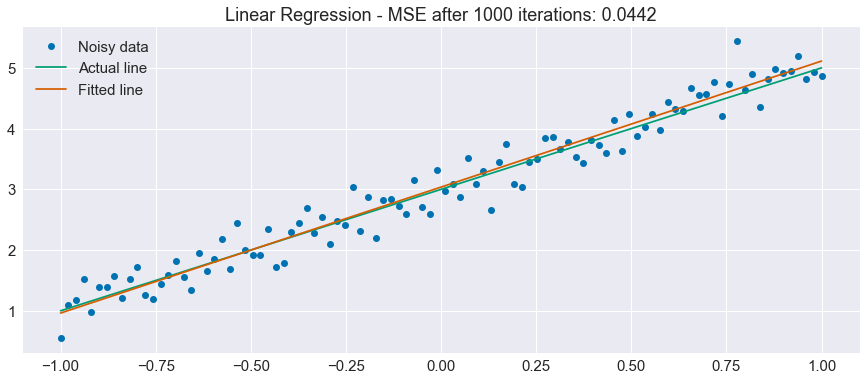

In [23]:
f, ax = plot_line(xs, y, ys=ys, predictions=y_hat_l)
ax.set_title(f'Linear Regression - MSE after {n_epochs_likelihood} iterations: {round(mse_l, 4)}')

In [24]:
all_mse = []
for learning_rate in [1.0, 0.1, 0.01, 0.001]:
    _, mse_l = train_likelihood(xs, ys, n_epochs_likelihood, batch_size_likelihood, learning_rate)
    all_mse.append(mse_l)

In [25]:
def plot_mse(learning_rates, all_mse):
    f, ax = plt.subplots(1, 1, figsize=(15, 6))
    
    x = range(0, len(all_mse[0]))
    
    for i, learning_rate in enumerate(learning_rates):
        ax.plot(x, np.log(all_mse[i]), label=f'η = {learning_rate}')

    ax.legend()
    
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Mean squared error (log scale)')
    
    return f, ax

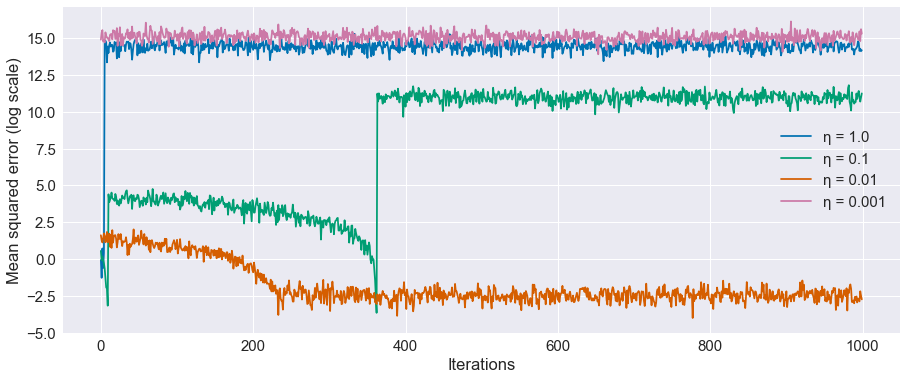

In [26]:
f, ax = plot_mse([1.0, 0.1, 0.01, 0.001], all_mse)

## Generate new points

In [27]:
def forecast_likelihood(x, y, save_path):
    x_scaler, y_scaler = preprocessing.StandardScaler(), preprocessing.StandardScaler()
    x_n = scale(x, x_scaler)
    y_n = scale(y, y_scaler)
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, save_path)
        
        y_hat_n, y_lik_n, mse_lik, stdev, slope_n, intercept_n = sess.run(
            [y_pred, y_likelihood, loss, sigma, a, b], 
            feed_dict={x_t: x_n, y_t: y_n}
        )

    y_hat = inverse_scale(y_hat_n, y_scaler)

    return (
        y_hat, 
        inverse_scale(y_lik_n, y_scaler), 
        float(stdev),
        float(mse_lik)
    )

In [28]:
_, y_lik, stdev, mse_l = forecast_likelihood(x_test, ys, likelihood_save_path)
print(f'stdev: {stdev}')

INFO:tensorflow:Restoring parameters from ./linreg_err_0.01.ckpt
stdev: 0.18907007575035095


In [29]:
def plot_new_data(x, y, y_hat):
    f, ax = plt.subplots(1, 1, figsize=(15, 6))
    
    palette = sns.color_palette('colorblind')
    
    ax.plot(x, y, 'o', label='Actual', color=palette[0])
    ax.plot(x, y_hat, 'o', label='Draw', color=palette[2])

    ax.legend()
    return f, ax

Text(0.5,1,'Draw from function')

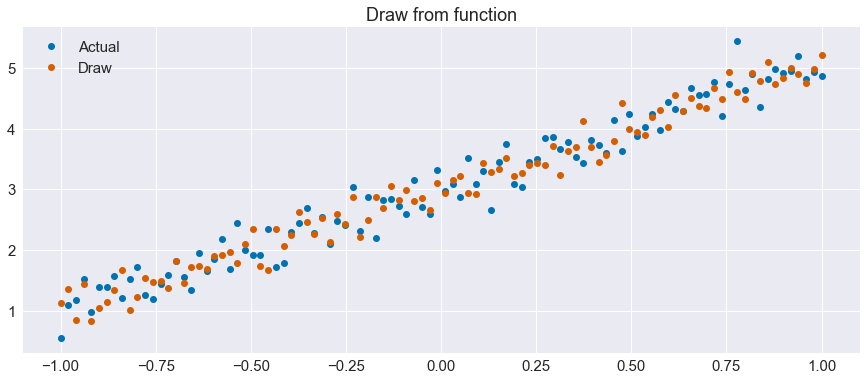

In [30]:
f, ax = plot_new_data(xs, ys, y_lik)
ax.set_title(f'Draw from function')

With error bars at +- 2 * sigma:

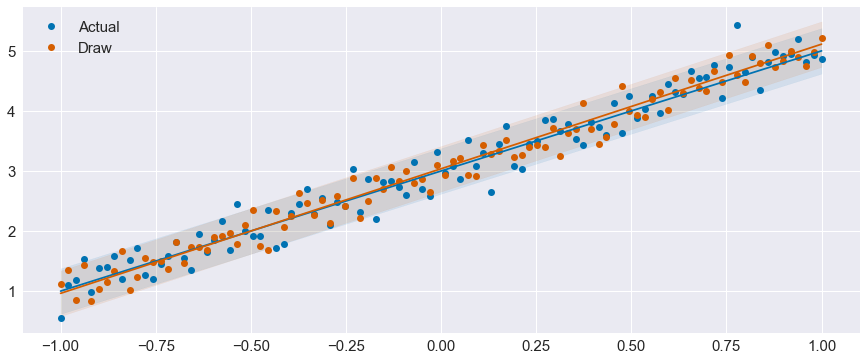

In [31]:
f, ax = plot_new_data(xs, ys, y_lik)

y_err_actual_low = y - 2 * stdev
y_err_actual_high = y + 2 * stdev

y_err_low = y_hat_l - 2 * stdev
y_err_high = y_hat_l + 2 * stdev

ax.plot(xs, y, '-', color=palette[0], alpha=1.0)
ax.fill_between(xs, y_err_actual_low, y_err_actual_high, color=palette[0], alpha=0.1)

ax.plot(xs, y_hat_l, '-', color=palette[2], alpha=1.0)
ax.fill_between(xs, y_err_low, y_err_high, color=palette[2], alpha=0.1)
                 
#ax.set_title(
#    'Linear regression with normal error '
#    f'(mse {round(mse_l, 2)} after {n_epochs_likelihood} iterations)'
#)
ax.legend()

## Bayesian Regression

How uncertain is our prediction?

#### Priors

In [32]:
a_values = np.linspace(1, 4, 50)
b_values = np.linspace(2, 5, 50)
sigma_values = np.linspace(0.1, 0.5, 50)

In [33]:
a_p = tf.placeholder(tf.float32, ())
b_p = tf.placeholder(tf.float32, ())
sigma_p = tf.placeholder(tf.float32, ())

def log_lyk_f(y, mu, s):
    return -tf.log(s * tf.sqrt(2 * tf.constant(math.pi))) - tf.divide(tf.square(y - mu), 2 * tf.square(s))

y_p = tf.add(tf.multiply(a_p, x_t), b_p)

log_lyk = log_lyk_f(y_t, y_p, sigma_p)
log_posterior = tf.reduce_sum(log_lyk)

In [34]:
def compute_posterior(a, b, s):
    with tf.Session() as sess:
        init.run()
        return sess.run(log_posterior, feed_dict={
            x_t: xs,
            y_t: ys,
            a_p: a,
            b_p: b,
            sigma_p: s,
        })
    
print(compute_posterior(5.0, 5.0, 0.1))
print(compute_posterior(5.0, 4.29, 0.34))
print(compute_posterior(2.0, 3.0, 0.25))

-34576.87
-1993.2505
-6.010625


In [35]:
def estimate_parameters(x_vals, y_vals, a_vals, b_vals, sigma_vals):
    output = np.zeros((len(a_vals), len(b_vals), len(sigma_vals)))
    with tf.Session() as sess:
        init.run()
        for i, a_v in enumerate(a_vals):
            if i == 0 or (i + 1) % 10 == 0:
                print(f'{i+1} / {len(a_vals)}')
            for j, b_v in enumerate(b_vals):
                for k, sigma_v in enumerate(sigma_vals):
                    log_post = sess.run(
                        [log_posterior], 
                        feed_dict={x_t: x_vals, y_t: y_vals, a_p: a_v, b_p: b_v, sigma_p: sigma_v}
                    )[0]
                    output[i][j][k] = log_post
    return np.exp(output - np.max(output))

In [48]:
def plot_marginal_distributions(a_values, b_values, sigma_values, output, save_path=None):
    f, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    p_a_marginalized = np.sum(output, axis=(1, 2))
    p_a_marginalized = p_a_marginalized / np.max(p_a_marginalized)
    axes[0].plot(a_values, p_a_marginalized)
    axes[0].set_title('Slope')
    
    p_b_marginalized = np.sum(output, axis=(0, 2))
    p_b_marginalized = p_b_marginalized / np.max(p_b_marginalized)
    axes[1].plot(b_values, p_b_marginalized)
    axes[1].set_title('Intercept')
    
    p_s_marginalized = np.sum(output, axis=(0, 1))
    p_s_marginalized = p_s_marginalized / np.max(p_s_marginalized)
    axes[2].plot(sigma_values, p_s_marginalized)
    axes[2].set_title('Sigma')
    
    if save_path is not None:
        f.savefig(save_path, bbox_inches='tight')

#### 10 data points

In [54]:
%%time
output = estimate_parameters(xs[:10], ys[:10], a_values, b_values, sigma_values)

1 / 50
10 / 50
20 / 50
30 / 50
40 / 50
50 / 50
CPU times: user 1min 28s, sys: 8.46 s, total: 1min 36s
Wall time: 1min 22s


In [55]:
am = np.unravel_index(output.argmax(), output.shape)
round(a_values[am[0]], 2), round(b_values[am[1]], 2), round(sigma_values[am[2]], 2)

(3.39, 4.33, 0.22)

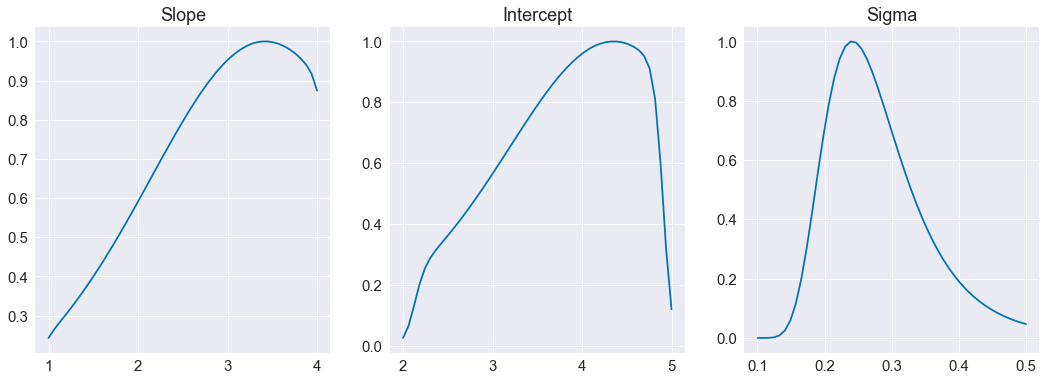

In [56]:
path = '/Users/srom/workspace/romainstrock.com/assets/img/linear_regression/brute_force_10.png'
plot_marginal_distributions(a_values, b_values, sigma_values, output)

#### 50 data points

In [57]:
%%time
output = estimate_parameters(xs[:30], ys[:30], a_values, b_values, sigma_values)

1 / 50
10 / 50
20 / 50
30 / 50
40 / 50
50 / 50
CPU times: user 1min 27s, sys: 8.44 s, total: 1min 35s
Wall time: 1min 20s


In [58]:
am = np.unravel_index(output.argmax(), output.shape)
round(a_values[am[0]], 2), round(b_values[am[1]], 2), round(sigma_values[am[2]], 2)

(1.8, 2.86, 0.25)

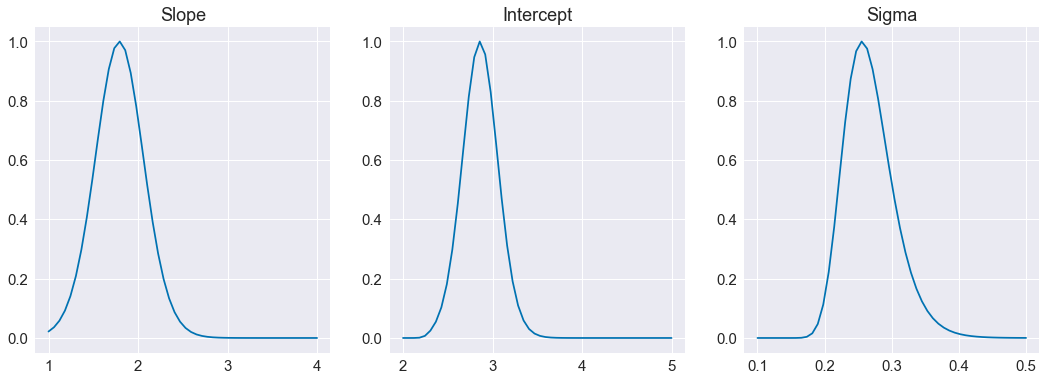

In [59]:
path = '/Users/srom/workspace/romainstrock.com/assets/img/linear_regression/brute_force_50.png'
plot_marginal_distributions(a_values, b_values, sigma_values, output)

#### 100 data points

In [60]:
%%time
output = estimate_parameters(xs, ys, a_values, b_values, sigma_values)

1 / 50
10 / 50
20 / 50
30 / 50
40 / 50
50 / 50
CPU times: user 1min 34s, sys: 9.02 s, total: 1min 43s
Wall time: 1min 29s


In [61]:
output[am]

5.18776556842227e-18

In [62]:
np.exp(-285.7)

8.35731016107229e-125

In [63]:
am = np.unravel_index(output.argmax(), output.shape)
round(a_values[am[0]], 2), round(b_values[am[1]], 2), round(sigma_values[am[2]], 2)

(2.04, 3.04, 0.26)

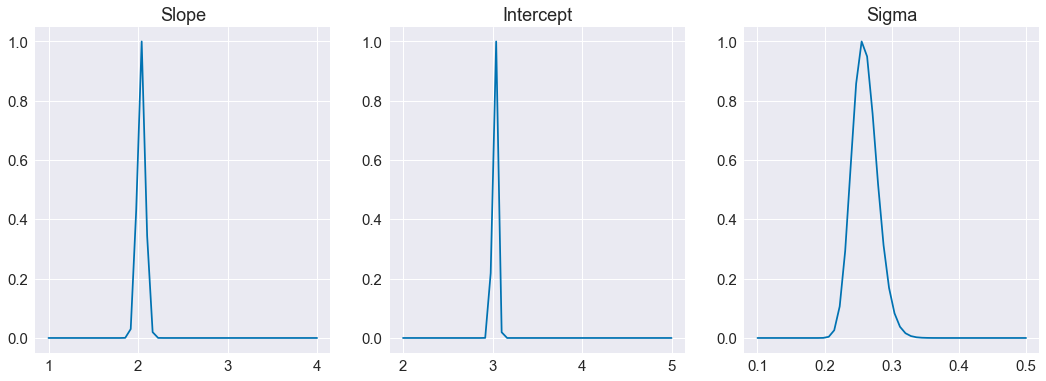

In [64]:
path = '/Users/srom/workspace/romainstrock.com/assets/img/linear_regression/brute_force_100.png'
plot_marginal_distributions(a_values, b_values, sigma_values, output)